In [12]:
import json
import numpy as np
import torchvision

import sys
import os
from collections import OrderedDict
sys.path.insert(0, './lavila')
from lavila.data.video_transforms import Permute
from lavila.models.models import VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL
from lavila.models.tokenizer import MyGPT2Tokenizer
import torchvision.transforms as transforms
import torchvision.transforms._transforms_video as transforms_video
import requests
from utils import *

In [16]:
file_path = r'C:\Users\kevin\OneDrive\Desktop\Ego4D\ego4d_data\v2\annotations\goalstep_train.json'
with open(file_path, 'r') as file:
    data = json.load(file)
videos = data['videos']


In [17]:
video_durations = {video['video_uid']: video['end_time'] - video['start_time'] for video in videos}
sorted_durations = dict(sorted(video_durations.items(), key=lambda item: item[1]))

In [18]:
# first 5 shortest video
list(sorted_durations.keys())[:5]

['2043d7fa-c369-431e-8bd4-3826c6c5d9cc',
 '793a9c9d-327e-4457-9c40-e626b2208aae',
 '82c57c2c-45e8-4a1e-b4b6-46b5c3fc1bf3',
 '28e0affc-cacb-4db8-ab32-dfc16931b86a',
 '487ca35f-25c6-4e5d-9ba9-d079bc4c162a']

In [19]:
video_index ={}
for i, video in enumerate(videos):
    video_index[video['video_uid']] = i


In [20]:
gaps = [get_total_gap(i) for i in videos]
flattened = list(itertools.chain(*gaps))
max_gap = max(flattened)
total_gap_duration_per_video = [np.sum(i) for i in gaps]
total_gap_count_per_video = [len(i) for i in gaps]

In [251]:
print(f"Average number of gaps per video: {np.mean(total_gap_count_per_video)},\n Average total gap time per video: {np.mean(total_gap_duration_per_video)},\n max gap time: {max_gap}")

Average number of gaps per video: 19.838765008576328,
 Average total gap time per video: 384.1032504959976,
 max gap time: 10913.314678645835


In [176]:
labeled_time_props = [0.0] * len(videos)
for i, video in enumerate(videos):
    gap_duration = np.sum(gaps[i])
    total_time = video['end_time'] - video['start_time']
    labeled_time_prop = (total_time - gap_duration) / total_time * 100
    labeled_time_props[i] = labeled_time_prop

In [ ]:
plt.hist(labeled_time_props)

In [ ]:
plt.hist(total_gap_count_per_video)

In [ ]:
plt.hist(total_gap_duration_per_video)

In [23]:
video_path = r'C:\Users\kevin\OneDrive\Desktop\Ego4D\793a9c9d-327e-4457-9c40-e626b2208aae.mp4'
file_name = os.path.splitext(os.path.basename(video_path))[0]
# video_path = r'C:\Users\kevin\OneDrive\Desktop\Ego4D\lavila\assets\3c0dffd0-e38e-4643-bc48-d513943dc20b_012_014.mp4'
stream = "video"
video = torchvision.io.VideoReader(video_path, stream)
file_name


'793a9c9d-327e-4457-9c40-e626b2208aae'

In [24]:
sample_video_id = video_index[file_name]
labeled_time = get_labeled_time_interval(videos[sample_video_id])
labeled_frames = read_frames_between_intervals(video, labeled_time)
for interval, frames_data in labeled_frames.items():
    print(f"Interval {interval} has {len(frames_data)} frames.")
    print(f"Positions of frames in the entire video: {[pos for pos, _, _ in frames_data]}")


Interval (0.01, 4.469) has 134 frames.
Positions of frames in the entire video: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134]
Interval (4.469, 6.735) has 67 frames.
Positions of frames in the entire video: [136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 1

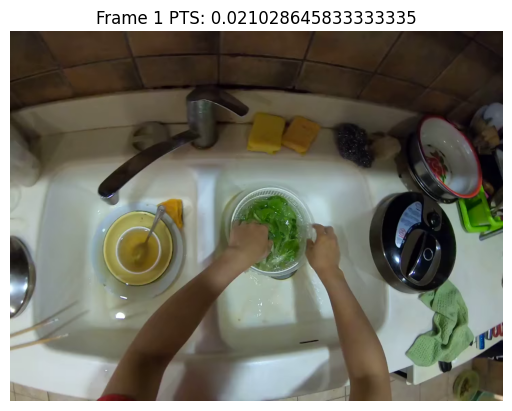

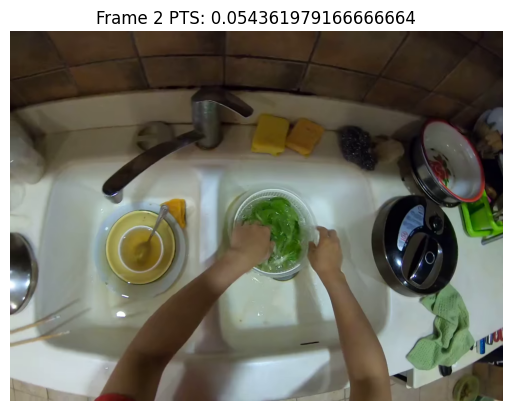

In [254]:
frames_data = list(labeled_frames.values())
visualize_frames(frames_data[0], n=2)

In [25]:
step_tensors ={}
for index, (interval, frames_data) in enumerate(labeled_frames.items()):
    step_descriptipn = labeled_time[interval]
    frame_tensor = [data for _, _, data in frames_data]
    frame_tensor = torch.stack(frame_tensor)
    step_tensors[f'{step_descriptipn}_{index}'] = frame_tensor


In [26]:
step0_tensors = step_tensors['Wash the mustard spinach in water_0']

In [2]:
!git clone https://github.com/facebookresearch/LaViLa.git lavila
%cd lavila

c:\Users\kevin\OneDrive\Desktop\Ego4D\lavila


Cloning into 'lavila'...


In [4]:
model_download_dir = r'C:\Users\kevin\OneDrive\Desktop\Ego4D\lavila\downloaded_models'
os.makedirs(model_download_dir, exist_ok=True)

In [9]:
# download the pre-trained weights
url = 'https://dl.fbaipublicfiles.com/lavila/checkpoints/narrator/vclm_openai_timesformer_large_336px_gpt2_xl.pt_ego4d.jobid_246897.ep_0003.md5sum_443263.pth'
response = requests.get(url)
model_path = os.path.join(model_download_dir, 'vclm_openai_timesformer_large_336px_gpt2_xl.pth')
if not os.path.exists(model_path):
    if response.status_code == 200:
        with open(model_path, 'wb') as file:
            file.write(response.content)
        print("Download completed successfully.")
    else:
        print(f"Failed to download the file. Status code: {response.status_code}")


Download completed successfully.


In [10]:
ckpt_path = pathlib.Path(model_path)
with set_posix_windows():
  ckpt = torch.load(ckpt_path, map_location='cpu')
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
  state_dict[k.replace('module.', '')] = v

C:\Users\kevin\AppData\Local\Temp\ipykernel_17772\4252881637.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location='cpu')


In [13]:
# transformers==4.35.2
model = VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL(
    text_use_cls_token=False,
    project_embed_dim=256,
    gated_xattn=True,
    timesformer_gated_xattn=False,
    freeze_lm_vclm=False,
    freeze_visual_vclm=False,
    freeze_visual_vclm_temporal=False,
    num_frames=4,
    drop_path_rate=0.
)
model.load_state_dict(state_dict, strict=True)
model.eval()

######USING ATTENTION STYLE:  frozen-in-time


100%|███████████████████████████████████████| 891M/891M [02:18<00:00, 6.76MiB/s]


=> Loading CLIP (ViT-L/14@336px) weights
_IncompatibleKeys(missing_keys=['temporal_embed', 'blocks.0.timeattn.qkv.weight', 'blocks.0.timeattn.qkv.bias', 'blocks.0.timeattn.proj.weight', 'blocks.0.timeattn.proj.bias', 'blocks.0.norm3.weight', 'blocks.0.norm3.bias', 'blocks.1.timeattn.qkv.weight', 'blocks.1.timeattn.qkv.bias', 'blocks.1.timeattn.proj.weight', 'blocks.1.timeattn.proj.bias', 'blocks.1.norm3.weight', 'blocks.1.norm3.bias', 'blocks.2.timeattn.qkv.weight', 'blocks.2.timeattn.qkv.bias', 'blocks.2.timeattn.proj.weight', 'blocks.2.timeattn.proj.bias', 'blocks.2.norm3.weight', 'blocks.2.norm3.bias', 'blocks.3.timeattn.qkv.weight', 'blocks.3.timeattn.qkv.bias', 'blocks.3.timeattn.proj.weight', 'blocks.3.timeattn.proj.bias', 'blocks.3.norm3.weight', 'blocks.3.norm3.bias', 'blocks.4.timeattn.qkv.weight', 'blocks.4.timeattn.qkv.bias', 'blocks.4.timeattn.proj.weight', 'blocks.4.timeattn.proj.bias', 'blocks.4.norm3.weight', 'blocks.4.norm3.bias', 'blocks.5.timeattn.qkv.weight', 'blocks

c:\Users\kevin\anaconda3\envs\ego4d\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\kevin\anaconda3\envs\ego4d\lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kevin\.cache\huggingface\hub\models--gpt2-xl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. I

VCLM_HF(
  (visual): SpaceTimeTransformer(
    (patch_embed): VideoPatchEmbed(
      (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    )
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-23): 24 x SpaceTimeBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): VarAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (timeattn): VarAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )


In [229]:
# torch.manual_seed(123)
# num_samples = 4
# random_indices = torch.randint(0, step0_tensors.size(0), (num_samples,))
# random_indices

tensor([58,  1, 84, 54])

In [27]:
sample_frames = step0_tensors
sample_frames = sample_frames.to(torch.float32)
sample_frames.shape

torch.Size([134, 3, 1080, 1440])

In [28]:
crop_size = 336
val_transform = transforms.Compose([
    Permute([1, 0, 2, 3]), # convert to [C, T, H, W]
    transforms.Resize(crop_size),
    transforms.CenterCrop(crop_size),
    transforms_video.NormalizeVideo(mean=[108.3272985, 116.7460125, 104.09373615000001], std=[68.5005327, 66.6321579, 70.32316305])

])
sample_frames = val_transform(sample_frames)
sample_frames.shape, sample_frames.dtype


(torch.Size([3, 134, 336, 336]), torch.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7463075..1.9975563].


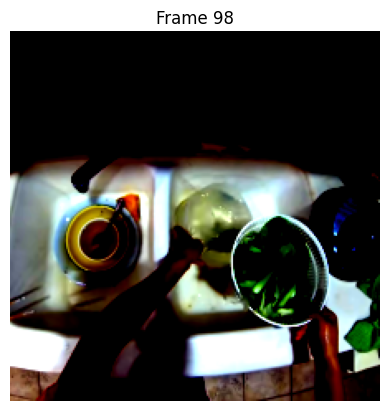

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7449101..2.1455545].


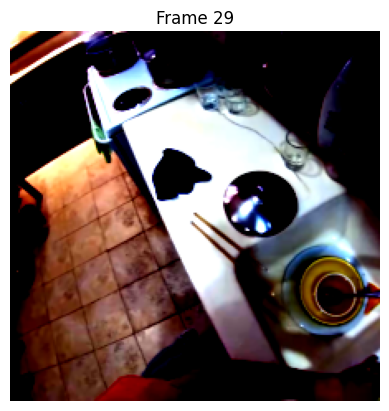

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7520971..1.950772].


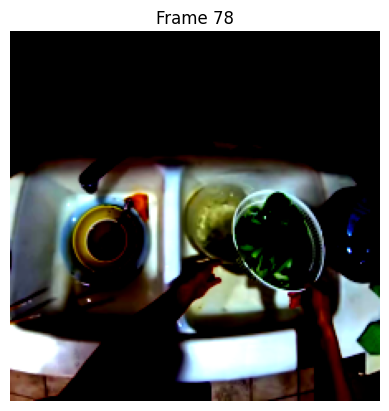

In [261]:
torch.manual_seed(123)
visualize_transformed_frames(sample_frames)

In [29]:
def decode_one(generated_ids, tokenizer):
    # get the index of <EOS>
    if tokenizer.eos_token_id == tokenizer.bos_token_id:
        if tokenizer.eos_token_id in generated_ids[1:].tolist():
            eos_id = generated_ids[1:].tolist().index(tokenizer.eos_token_id) + 1
        else:
            eos_id = len(generated_ids.tolist()) - 1
    elif tokenizer.eos_token_id in generated_ids.tolist():
        eos_id = generated_ids.tolist().index(tokenizer.eos_token_id)
    else:
        eos_id = len(generated_ids.tolist()) - 1
    generated_text_str = tokenizer.tokenizer.decode(generated_ids[1:eos_id].tolist())
    return generated_text_str

In [264]:
# tokenizer = MyGPT2Tokenizer('gpt2', add_bos=True)
# # sample_frames = sample_frames.unsqueeze(0) 
# print(sample_frames.shape)
# with torch.no_grad():
#   image_features = model.encode_image(sample_frames[:,:, :4, :, :])
#   generated_text_ids, ppls = model.generate(
#       image_features,
#       tokenizer,
#       target=None, # free-form generation
#       max_text_length=77,
#       top_k=None,
#       top_p=0.95,  # nucleus sampling
#       num_return_sequences=3, # number of candidates
#       temperature=0.5,
#       early_stopping=True,
#   )
# for i in range(3):
#   generated_text_str = decode_one(generated_text_ids[i], tokenizer)
#   print('{}: {}'.format(i, generated_text_str))

In [30]:
# sample_frames shape is [1, 3, 126, 336, 336]
chunk_size = 4

descriptions = []
k_candidate  = 3
tokenizer = MyGPT2Tokenizer('gpt2-xl', add_bos=True)
input = sample_frames.unsqueeze(0) 
for i in range(0, input.size(2),chunk_size):
    frame_chunk = input[:, :, i: i + chunk_size, :, :]
    frame_des = []
    with torch.no_grad():
        image_features = model.encode_image(frame_chunk)  
        generated_text_ids,_ = model.generate(
            image_features,
            tokenizer,
            target=None,
            max_text_length=77,
            top_k=None,
            top_p=0.95,
            num_return_sequences=k_candidate,  
            temperature=0.5,
            early_stopping=True,
        )
    
    for i in range(k_candidate):
        generated_text_str = decode_one(generated_text_ids[i], tokenizer)
        frame_des.append(generated_text_str)

    descriptions.append(frame_des)

for i, description in enumerate(descriptions):
    print(f"Frame chunk {i}: {description}")


=> Initialize MyGPT2Tokenizer (gpt2-xl)


c:\Users\kevin\anaconda3\envs\ego4d\lib\site-packages\huggingface_hub\file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Frame chunk 0: ['#C C picks the spinach ', '#C C picks the spinach from the str', '#C C shakes the greens']
Frame chunk 1: ['#C C washes the spinach', '#C C washes the greens', '#C C picks up the vegetables from the s']
Frame chunk 2: ['#C C holds the sieve with both hands', '#C C holds the colander', '#C C holds the bowl']
Frame chunk 3: ['#C C looks', '#C C looks', '#C C looks']
Frame chunk 4: ['#C C looks', '#C C looks', '#C C looks']
Frame chunk 5: ['#C C looks', '#C C looks', '#C C looks']
Frame chunk 6: ['#O person X walks', '#C C looks around', '#C C looks around']
Frame chunk 7: ['#C C looks', '#C C looks', '#C C looks']
Frame chunk 8: ['#C C looks at the sink', '#C C looks around', '#C C looks around']
Frame chunk 9: ['#C C looks at the', '#C C looks around', '#C C looks around']
Frame chunk 10: ['#C C looks', '#C C looks', '#C C looks']
Frame chunk 11: ['#C C looks around', '#C C looks around', '#C C looks around']
Frame chunk 12: ['#C C looks', '#C C looks', '#C C looks']
Fr